In [1]:
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(notebook_dir)

if project_dir not in sys.path:
    sys.path.append(project_dir)

import pandas as pd
import numpy as np

In [2]:
all_fighter_cluster = pd.read_csv(r"https://raw.githubusercontent.com/john-adeojo/ufc_styles/main/data/02_intermediate/all_fighter_clusters.csv")
fighter_data = pd.read_csv(r"https://github.com/john-adeojo/ufc_styles/blob/main/data/02_intermediate/fighter_data.csv?raw=true")

In [3]:
analysis_data_base = fighter_data.merge(right=all_fighter_cluster[['cluster','specific_cluster', 'Fighter_dims', 'weight_class']], how='left', left_on=['Fighter_dims', 'weight_class'], right_on=['Fighter_dims', 'weight_class'])
analysis_data_base = analysis_data_base.dropna(subset=['cluster'])
analysis_data_opp = analysis_data_base.copy()
analysis_data_opp['opp_specific_cluster'] = analysis_data_opp['specific_cluster']
analysis_data = analysis_data_base.merge(right=analysis_data_opp[['weight_class', 'Fighter_dims', 'date', 'opp_specific_cluster']], how='inner', left_on=['weight_class', 'Opponent', 'date'], right_on=['weight_class', 'Fighter_dims', 'date'] )
analysis_data_opposing_styles = analysis_data.loc[analysis_data['opp_specific_cluster'] != analysis_data['specific_cluster']].copy()
analysis_data_opposing_styles

,Unnamed: 0,R_fighter,B_fighter,date,Winner,weight_class,avg_KD,avg_opp_KD,avg_SUB_ATT,avg_opp_SUB_ATT,...,Stance_Southpaw,Stance_Switch,Stance_nan,fighter,method,fighter_result,cluster,specific_cluster,Fighter_dims_y,opp_specific_cluster
4,4,Arman Tsarukyan,Mateusz Gamrot,2022-06-25,Blue,Lightweight,0.000291,0.000291,0.000582,0.000000,...,1.0,0.0,0.0,Mateusz Gamrot,U-DEC,Win by U-DEC,0.0,0_Lightweight,Arman Tsarukyan,2_Lightweight
6,6,Shayilan Nuerdanbieke,TJ Brown,2022-06-25,Red,Featherweight,0.000000,0.000293,0.002053,0.001027,...,0.0,1.0,0.0,TJ Brown,U-DEC,Loss by U-DEC,0.0,0_Featherweight,Shayilan Nuerdanbieke,1_Featherweight
8,8,Vanessa Demopoulos,Jinh Yu Frey,2022-06-25,Red,WomenStrawweight,0.000000,0.000000,0.000568,0.000142,...,1.0,0.0,0.0,Jinh Yu Frey,S-DEC,Loss by S-DEC,0.0,0_WomenStrawweight,Vanessa Demopoulos,1_WomenStrawweight
9,9,JP Buys,Cody Durden,2022-06-25,Blue,Flyweight,0.000000,0.001278,0.000319,0.001917,...,1.0,0.0,0.0,Cody Durden,KO/TKO,Win by KO/TKO,0.0,0_Flyweight,JP Buys,2_Flyweight
15,18,Court McGee,Jeremiah Wells,2022-06-18,Blue,Welterweight,0.001645,0.000000,0.001645,0.001645,...,0.0,1.0,0.0,Jeremiah Wells,KO/TKO,Win by KO/TKO,0.0,0_Welterweight,Court McGee,2_Welterweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,10305,Chuck Liddell,Vitor Belfort,2002-06-22,Red,LightHeavyweight,0.000487,0.000000,0.000000,0.000061,...,0.0,0.0,0.0,Chuck Liddell,U-DEC,Win by U-DEC,1.0,1_LightHeavyweight,Vitor Belfort,0_LightHeavyweight
7408,10318,Jens Pulver,BJ Penn,2002-01-11,Red,Lightweight,0.000103,0.000000,0.000488,0.001233,...,1.0,0.0,0.0,Jens Pulver,M-DEC,Win by M-DEC,0.0,0_Lightweight,BJ Penn,2_Lightweight
7409,10322,BJ Penn,Caol Uno,2001-11-02,Red,Lightweight,0.002179,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,BJ Penn,KO/TKO,Win by KO/TKO,2.0,2_Lightweight,Caol Uno,0_Lightweight
7410,10323,Matt Lindland,Phil Baroni,2001-11-02,Red,Middleweight,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,Matt Lindland,M-DEC,Win by M-DEC,0.0,0_Middleweight,Phil Baroni,2_Middleweight


In [4]:
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['corner'] == 'Red'].copy()
analysis_data_opposing_styles

,Unnamed: 0,R_fighter,B_fighter,date,Winner,weight_class,avg_KD,avg_opp_KD,avg_SUB_ATT,avg_opp_SUB_ATT,...,Stance_Southpaw,Stance_Switch,Stance_nan,fighter,method,fighter_result,cluster,specific_cluster,Fighter_dims_y,opp_specific_cluster
3712,4735,Arman Tsarukyan,Mateusz Gamrot,2022-06-25,Blue,Lightweight,0.000537,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,Arman Tsarukyan,U-DEC,Loss by U-DEC,2.0,2_Lightweight,Mateusz Gamrot,0_Lightweight
3714,4737,Shayilan Nuerdanbieke,TJ Brown,2022-06-25,Red,Featherweight,0.000000,0.000000,0.000000,0.000556,...,0.0,0.0,0.0,Shayilan Nuerdanbieke,U-DEC,Win by U-DEC,1.0,1_Featherweight,TJ Brown,0_Featherweight
3716,4739,Vanessa Demopoulos,Jinh Yu Frey,2022-06-25,Red,WomenStrawweight,0.000000,0.000957,0.001914,0.000000,...,0.0,0.0,0.0,Vanessa Demopoulos,S-DEC,Win by S-DEC,1.0,1_WomenStrawweight,Jinh Yu Frey,0_WomenStrawweight
3717,4740,JP Buys,Cody Durden,2022-06-25,Blue,Flyweight,0.000000,0.005087,0.002907,0.000727,...,0.0,0.0,0.0,JP Buys,KO/TKO,Loss by KO/TKO,2.0,2_Flyweight,Cody Durden,0_Flyweight
3723,4750,Court McGee,Jeremiah Wells,2022-06-18,Blue,Welterweight,0.000608,0.000210,0.000837,0.000565,...,0.0,0.0,0.0,Court McGee,KO/TKO,Loss by KO/TKO,2.0,2_Welterweight,Jeremiah Wells,0_Welterweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,10305,Chuck Liddell,Vitor Belfort,2002-06-22,Red,LightHeavyweight,0.000487,0.000000,0.000000,0.000061,...,0.0,0.0,0.0,Chuck Liddell,U-DEC,Win by U-DEC,1.0,1_LightHeavyweight,Vitor Belfort,0_LightHeavyweight
7408,10318,Jens Pulver,BJ Penn,2002-01-11,Red,Lightweight,0.000103,0.000000,0.000488,0.001233,...,1.0,0.0,0.0,Jens Pulver,M-DEC,Win by M-DEC,0.0,0_Lightweight,BJ Penn,2_Lightweight
7409,10322,BJ Penn,Caol Uno,2001-11-02,Red,Lightweight,0.002179,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,BJ Penn,KO/TKO,Win by KO/TKO,2.0,2_Lightweight,Caol Uno,0_Lightweight
7410,10323,Matt Lindland,Phil Baroni,2001-11-02,Red,Middleweight,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,Matt Lindland,M-DEC,Win by M-DEC,0.0,0_Middleweight,Phil Baroni,2_Middleweight


In [5]:
import pandas as pd

# Assuming your DataFrame is named 'analysis_data_opposing_styles'
# and the columns to combine are 'specific_cluster' and 'opp_specific_cluster'

def create_style_matchup(row):
    # Combine the two columns and sort them alphabetically
    matchup = sorted([row['specific_cluster'], row['opp_specific_cluster']])
    
    # Join them with ' vs. ' and return the result
    return matchup[0] + ' vs. ' + matchup[1]

# Apply the custom function to each row and create the new 'style_matchup' column
analysis_data_opposing_styles['style_matchup'] = analysis_data_opposing_styles.apply(create_style_matchup, axis=1)

# Display the DataFrame
analysis_data_opposing_styles.sort_values(by='weight_class', inplace=True)


In [6]:
weight_class = list(analysis_data_opposing_styles['weight_class'].drop_duplicates())
weight_class

['Bantamweight',
 'CatchWeight',
 'Featherweight',
 'Flyweight',
 'Heavyweight',
 'LightHeavyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight',
 'WomenFlyweight',
 'WomenStrawweight']

In [7]:
# from scripts.chisquareanalysis import ChiSquareAnalysis

# # Assuming weight_class is a list of weight classes

# # Initialize an empty dictionary to store the results
# results_dict = {}

# for weights in weight_class:
#     analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, category=weights)
#     result = analysis.run_chisquare_analysis('fighter_result')
    
#     # Save the result in the dictionary with the weight as the key
#     results_dict[weights] = result

# # Display the results dictionary
# results_dict

In [8]:
fighter_result = list(analysis_data_opposing_styles['fighter_result'].drop_duplicates())

In [9]:
from scripts.chisquareanalysis import ChiSquareAnalysis
analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, category='Bantamweight')
result_batamweight = analysis.run_chisquare_analysis('fighter_result')
result_batamweight

Chi2 Stat: 25.445339684125397
P Value: 0.11313278683751908
Degrees of Freedom: 18


fighter_result,style_matchup,Draw by DRAW,Loss by DQ,Loss by KO/TKO,Loss by S-DEC,Loss by SUB,Loss by U-DEC,Win by KO/TKO,Win by S-DEC,Win by SUB,Win by U-DEC
0,0_Bantamweight vs. 1_Bantamweight,-0.268462,-0.268462,-0.465046,-0.710285,2.105487,-0.967955,2.372895,-0.657596,-0.890389,-0.597329
1,0_Bantamweight vs. 2_Bantamweight,0.465129,-0.794123,-0.234612,-0.197242,0.278711,-0.418475,-0.994709,0.625241,1.162980,0.310842
2,1_Bantamweight vs. 2_Bantamweight,-0.545250,1.288772,0.570670,0.636990,-1.442595,1.086071,0.280400,-0.586847,-1.255410,-0.158618


In [10]:
analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, category='Welterweight')
result_welterweight = analysis.run_chisquare_analysis('fighter_result')
result_welterweight

Chi2 Stat: 29.58163137025438
P Value: 0.12899242587996712
Degrees of Freedom: 22


fighter_result,style_matchup,Draw by DRAW,Loss by KO/TKO,Loss by M-DEC,Loss by S-DEC,Loss by SUB,Loss by U-DEC,Win by DQ,Win by KO/TKO,Win by M-DEC,Win by S-DEC,Win by SUB,Win by U-DEC
0,0_Welterweight vs. 1_Welterweight,-0.693613,-1.550967,-0.370752,0.858578,-0.945236,0.304017,-0.262161,-0.128104,-0.370752,1.295767,1.742211,-0.639115
1,0_Welterweight vs. 2_Welterweight,-1.074541,0.094394,-0.574367,-1.624554,1.950124,-1.478994,-0.406138,0.448013,-0.574367,-1.323861,1.432223,1.119314
2,1_Welterweight vs. 2_Welterweight,0.706251,0.420684,0.377507,0.496583,-0.621678,0.595129,0.266938,-0.169490,0.377507,0.226149,-1.186226,-0.327902


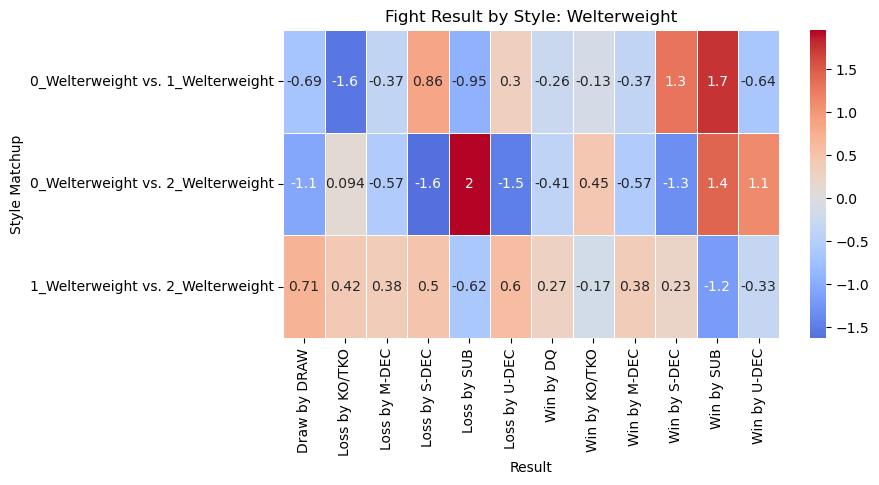

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

result_welterweight_col = result_welterweight.drop(columns=['style_matchup']).columns

# Prepare the data for the heatmap
heatmap_data = result_welterweight.set_index('style_matchup')[result_welterweight_col]

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
plt.title('Fight Result by Style: Welterweight')
plt.xlabel('Result')
plt.ylabel('Style Matchup')
#plt.savefig(r"C:\Users\johna\anaconda3\envs\twitter-influence-env\twitter-influence\data\03_reports\sentiment_heatmap.png")
plt.show()


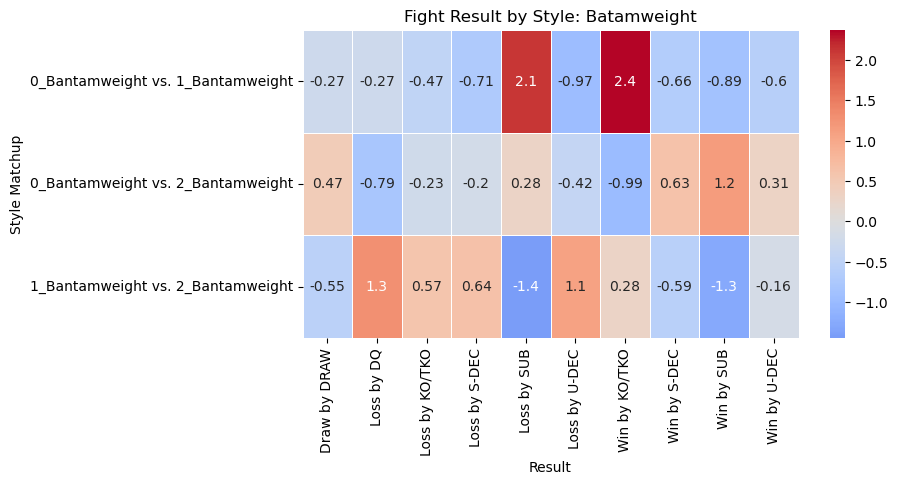

In [13]:
result_batamweight_col = result_batamweight.drop(columns=['style_matchup']).columns

# Prepare the data for the heatmap
heatmap_data = result_batamweight.set_index('style_matchup')[result_batamweight_col]

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
plt.title('Fight Result by Style: Batamweight')
plt.xlabel('Result')
plt.ylabel('Style Matchup')
#plt.savefig(r"C:\Users\johna\anaconda3\envs\twitter-influence-env\twitter-influence\data\03_reports\sentiment_heatmap.png")
plt.show()

In [15]:
import requests
import json
# import style dims
url = 'https://github.com/john-adeojo/ufc_styles/raw/main/data/02_intermediate/style_dims_names.json'

# Fetch the JSON file content
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    try:
        # Load the content into a list
        style_dims_names = json.loads(response.text)
        print("Data loaded successfully:")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
else:
    print(f"Failed to fetch JSON file: {response.status_code}")

Data loaded successfully:


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_fighter_cluster is a DataFrame and style_dims_names is a list of columns

# Calculate the number of variables (dimensions) and the angle of each axis
def radar_chart(specific_cluster):
    num_vars = len(style_dims_names)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Prepare the radar chart (polar plot)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Plot the data for each row in the DataFrame
    data = all_fighter_cluster.loc[all_fighter_cluster['specific_cluster'] == specific_cluster]
    for index, row in data.iterrows():
        print("style_dims_names:", style_dims_names)
        print("Row columns:", row.index)
        values = row[style_dims_names].tolist()
        values += values[:1]  # Repeat the first value to close the circle
        print("Values:", values)
        ax.plot(angles, values, label=row['Fighter_dims'])  # Assuming 'fighter_name' is a column in the DataFrame
        
        print(f"len(style_dims_names): {len(style_dims_names)}")
        print(f"len(angles): {len(angles)}")
        print(f"len(values): {len(values)}")

    # Configure the radar chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), style_dims_names)
    ax.set_rlabel_position(180 / num_vars)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the radar chart
    plt.show()


style_dims_names: ['avg_KD', 'avg_opp_KD', 'avg_SUB_ATT', 'avg_opp_SUB_ATT', 'avg_REV', 'avg_opp_REV', 'avg_SIG_STR_att', 'avg_SIG_STR_landed', 'avg_opp_SIG_STR_att', 'avg_opp_SIG_STR_landed', 'avg_TOTAL_STR_att', 'avg_TOTAL_STR_landed', 'avg_opp_TOTAL_STR_att', 'avg_opp_TOTAL_STR_landed', 'avg_TD_att', 'avg_TD_landed', 'avg_opp_TD_att', 'avg_opp_TD_landed', 'avg_HEAD_att', 'avg_HEAD_landed', 'avg_opp_HEAD_att', 'avg_opp_HEAD_landed', 'avg_BODY_att', 'avg_BODY_landed', 'avg_opp_BODY_att', 'avg_opp_BODY_landed', 'avg_LEG_att', 'avg_LEG_landed', 'avg_opp_LEG_att', 'avg_opp_LEG_landed', 'avg_DISTANCE_att', 'avg_DISTANCE_landed', 'avg_opp_DISTANCE_att', 'avg_opp_DISTANCE_landed', 'avg_CLINCH_att', 'avg_CLINCH_landed', 'avg_opp_CLINCH_att', 'avg_opp_CLINCH_landed', 'avg_GROUND_att', 'avg_GROUND_landed', 'avg_opp_GROUND_att', 'avg_opp_GROUND_landed', 'avg_CTRL_time(seconds)', 'avg_opp_CTRL_time(seconds)', 'Stance_Open Stance', 'Stance_Orthodox', 'Stance_Sideways', 'Stance_Southpaw', 'Stance_

ValueError: x and y must have same first dimension, but have shapes (49,) and (50,)

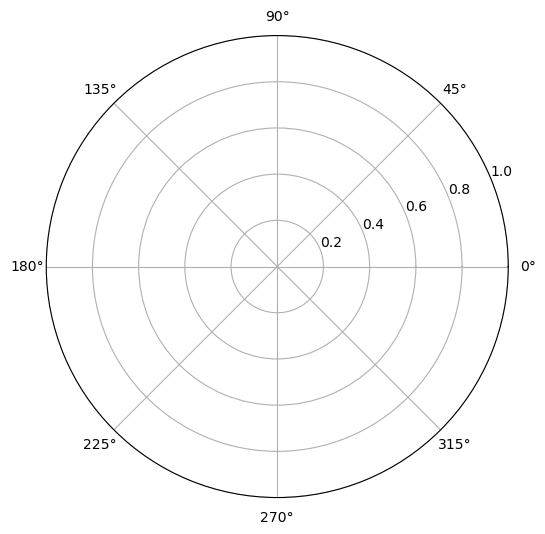

In [31]:
radar_chart(specific_cluster="0_Welterweight")

In [26]:
len(style_dims_names)

49

In [27]:
style_dims_names

['avg_KD',
 'avg_opp_KD',
 'avg_SUB_ATT',
 'avg_opp_SUB_ATT',
 'avg_REV',
 'avg_opp_REV',
 'avg_SIG_STR_att',
 'avg_SIG_STR_landed',
 'avg_opp_SIG_STR_att',
 'avg_opp_SIG_STR_landed',
 'avg_TOTAL_STR_att',
 'avg_TOTAL_STR_landed',
 'avg_opp_TOTAL_STR_att',
 'avg_opp_TOTAL_STR_landed',
 'avg_TD_att',
 'avg_TD_landed',
 'avg_opp_TD_att',
 'avg_opp_TD_landed',
 'avg_HEAD_att',
 'avg_HEAD_landed',
 'avg_opp_HEAD_att',
 'avg_opp_HEAD_landed',
 'avg_BODY_att',
 'avg_BODY_landed',
 'avg_opp_BODY_att',
 'avg_opp_BODY_landed',
 'avg_LEG_att',
 'avg_LEG_landed',
 'avg_opp_LEG_att',
 'avg_opp_LEG_landed',
 'avg_DISTANCE_att',
 'avg_DISTANCE_landed',
 'avg_opp_DISTANCE_att',
 'avg_opp_DISTANCE_landed',
 'avg_CLINCH_att',
 'avg_CLINCH_landed',
 'avg_opp_CLINCH_att',
 'avg_opp_CLINCH_landed',
 'avg_GROUND_att',
 'avg_GROUND_landed',
 'avg_opp_GROUND_att',
 'avg_opp_GROUND_landed',
 'avg_CTRL_time(seconds)',
 'avg_opp_CTRL_time(seconds)',
 'Stance_Open Stance',
 'Stance_Orthodox',
 'Stance_Sideways',